<a href="https://colab.research.google.com/github/Ksywwa/ML/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [ ]:
!pip install pandas scikit-learn seaborn scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [ ]:
# Загрузка набора данных
df = pd.read_csv('/content/sample_data/heart.csv')

In [ ]:
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0


In [ ]:
df['is_alive'] = np.where(df['DEATH'] > 0, 1, 0).astype(int)

In [ ]:
Y = df['is_alive'] # выбираем целевую переменную (категориальную)
X = df.drop('is_alive', axis=1) # переменные для проверки влияния

X = X.drop('DEATH', axis=1)

In [ ]:
df.drop('DEATH', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   CHOL_50    200 non-null    int64
 7   SES        200 non-null    int64
 8   CL_STATUS  200 non-null    int64
 9   MD_62      200 non-null    int64
 10  SBP_62     200 non-null    int64
 11  DBP_62     200 non-null    int64
 12  CHOL_62    200 non-null    int64
 13  WT_62      200 non-null    int64
 14  IHD_DX     200 non-null    int64
 15  is_alive   200 non-null    int64
dtypes: int64(16)
memory usage: 25.1 KB


In [ ]:
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH,is_alive
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1,1
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1,1
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0,0


## 2: масштабирование признаков

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   AGE_50     200 non-null    int64
 1   MD_50      200 non-null    int64
 2   SBP_50     200 non-null    int64
 3   DBP_50     200 non-null    int64
 4   HT_50      200 non-null    int64
 5   WT_50      200 non-null    int64
 6   CHOL_50    200 non-null    int64
 7   SES        200 non-null    int64
 8   CL_STATUS  200 non-null    int64
 9   MD_62      200 non-null    int64
 10  SBP_62     200 non-null    int64
 11  DBP_62     200 non-null    int64
 12  CHOL_62    200 non-null    int64
 13  WT_62      200 non-null    int64
 14  IHD_DX     200 non-null    int64
dtypes: int64(15)
memory usage: 23.6 KB


In [ ]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [ ]:
X_processed

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0


In [ ]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [ ]:
X_processed

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [ ]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [ ]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.7562
Точность на тестовой выборке: 0.6750

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        27
           1       0.50      0.23      0.32        13

    accuracy                           0.68        40
   macro avg       0.60      0.56      0.55        40
weighted avg       0.64      0.68      0.63        40



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [ ]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [ ]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [ ]:
X_processed.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,46.06500,2.360000,124.700000,83.380000,68.160000,168.075000,258.105000,2.915000,7.650000,2.315000,141.480000,84.820000,254.070000,167.375000,1.410000
std,10.81274,1.017633,18.114654,11.000484,2.768161,26.639589,55.524126,1.069342,1.119718,1.197055,24.656833,12.808116,46.509686,27.516178,2.464196
min,20.00000,1.000000,88.000000,38.000000,61.000000,109.000000,120.000000,1.000000,0.000000,1.000000,70.000000,56.000000,139.000000,108.000000,0.000000
25%,38.00000,1.000000,110.000000,78.000000,66.000000,147.000000,220.000000,2.000000,8.000000,1.000000,125.000000,76.000000,222.750000,148.750000,0.000000
50%,47.00000,2.000000,120.000000,80.000000,68.000000,165.000000,250.000000,3.000000,8.000000,2.000000,138.000000,83.000000,251.500000,165.500000,0.000000
75%,54.00000,3.000000,130.000000,90.000000,70.000000,189.000000,295.000000,3.000000,8.000000,3.000000,155.000000,90.000000,283.250000,187.000000,2.000000
max,69.00000,4.000000,210.000000,140.000000,75.000000,245.000000,535.000000,5.000000,8.000000,5.000000,230.000000,125.000000,368.000000,246.000000,9.000000


In [ ]:
X_iqr.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.0,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,45.628049,2.359756,120.201220,81.219512,68.317073,166.695122,253.567073,2.920732,8.0,2.365854,138.152439,83.628049,254.890244,167.164634,1.048780
std,10.807380,1.026563,12.791475,7.936905,2.735264,26.358635,50.112283,1.002970,0.0,1.187999,22.837542,11.905639,45.397091,27.988227,1.914763
min,22.000000,1.000000,88.000000,55.000000,62.000000,109.000000,120.000000,1.000000,8.0,1.000000,70.000000,56.000000,150.000000,108.000000,0.000000
25%,37.750000,1.000000,110.000000,78.000000,66.000000,146.750000,220.000000,2.000000,8.0,1.000000,123.500000,75.000000,223.750000,147.000000,0.000000
50%,46.500000,2.000000,120.000000,80.000000,69.000000,163.000000,250.000000,3.000000,8.0,2.000000,134.500000,80.000000,251.500000,165.500000,0.000000
75%,53.250000,3.000000,130.000000,90.000000,70.000000,188.250000,290.000000,3.000000,8.0,3.000000,150.000000,90.000000,284.250000,187.000000,2.000000
max,69.000000,4.000000,160.000000,100.000000,75.000000,235.000000,439.000000,5.000000,8.0,5.000000,230.000000,120.000000,367.000000,246.000000,7.000000


In [ ]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.7710
Точность на тестовой выборке: 0.7879

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        22
           1       0.67      0.73      0.70        11

    accuracy                           0.79        33
   macro avg       0.76      0.77      0.77        33
weighted avg       0.79      0.79      0.79        33



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

Для большинства числовых признаков стандартное отклонение уменьшилось после удаления выбросов. Это указывает на то, что данные стали менее разбросанными, более сгруппированными вокруг среднего значения. Максимальные значения  для некоторых переменных (например, WT_50, CHOL_50, CHOL_62) значительно уменьшились. Это прямое следствие удаления экстремальных значений, которые ранее выступали в роли выбросов. После удаления выбросов точность модели немного улучшилась

### Метод 2: удаление на основе среднего

In [ ]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [ ]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [ ]:
X_processed.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,46.06500,2.360000,124.700000,83.380000,68.160000,168.075000,258.105000,2.915000,7.650000,2.315000,141.480000,84.820000,254.070000,167.375000,1.410000
std,10.81274,1.017633,18.114654,11.000484,2.768161,26.639589,55.524126,1.069342,1.119718,1.197055,24.656833,12.808116,46.509686,27.516178,2.464196
min,20.00000,1.000000,88.000000,38.000000,61.000000,109.000000,120.000000,1.000000,0.000000,1.000000,70.000000,56.000000,139.000000,108.000000,0.000000
25%,38.00000,1.000000,110.000000,78.000000,66.000000,147.000000,220.000000,2.000000,8.000000,1.000000,125.000000,76.000000,222.750000,148.750000,0.000000
50%,47.00000,2.000000,120.000000,80.000000,68.000000,165.000000,250.000000,3.000000,8.000000,2.000000,138.000000,83.000000,251.500000,165.500000,0.000000
75%,54.00000,3.000000,130.000000,90.000000,70.000000,189.000000,295.000000,3.000000,8.000000,3.000000,155.000000,90.000000,283.250000,187.000000,2.000000
max,69.00000,4.000000,210.000000,140.000000,75.000000,245.000000,535.000000,5.000000,8.000000,5.000000,230.000000,125.000000,368.000000,246.000000,9.000000


In [ ]:
X_mean.describe()

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,45.961538,2.415385,121.269231,81.453846,68.107692,162.946154,252.776923,2.961538,7.930769,2.284615,138.407692,83.453846,252.215385,161.838462,1.000000
std,9.939666,1.002204,13.787304,8.313724,2.484826,22.372225,43.824927,0.918406,0.309750,1.122253,20.256761,11.709740,39.565662,23.423570,1.880129
min,25.000000,1.000000,100.000000,64.000000,63.000000,121.000000,150.000000,1.000000,6.000000,1.000000,100.000000,60.000000,169.000000,113.000000,0.000000
25%,39.250000,2.000000,110.000000,78.000000,66.000000,145.000000,220.000000,2.250000,8.000000,1.000000,124.250000,75.000000,224.250000,146.000000,0.000000
50%,46.000000,2.000000,120.000000,80.000000,69.000000,160.500000,250.000000,3.000000,8.000000,2.000000,135.000000,80.000000,251.000000,161.000000,0.000000
75%,53.000000,3.000000,130.000000,90.000000,70.000000,179.500000,288.000000,3.000000,8.000000,3.000000,150.000000,90.000000,277.500000,178.750000,2.000000
max,65.000000,4.000000,160.000000,105.000000,73.000000,215.000000,363.000000,5.000000,8.000000,4.000000,190.000000,110.000000,338.000000,213.000000,6.000000


In [ ]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.8269
Точность на тестовой выборке: 0.6154

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       0.33      0.25      0.29         8

    accuracy                           0.62        26
   macro avg       0.52      0.51      0.51        26
weighted avg       0.59      0.62      0.60        26



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

 Как и в случае с первым методом, стандартное отклонение для большинства признаков значительно уменьшилось, что указывает на уменьшение разброса данных.
Метод удаления выбросов на основе среднего значения и стандартного отклонения, хотя и улучшил точность на обучающей выборке, привел к значительному переобучению и ухудшению обобщающей способности модели на тестовой выборке.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression


In [ ]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed, Y)


In [ ]:
selector.scores_

array([  15.91944785,  153.01798505,   19.30973434,   26.70616096,
        174.56414947,    1.41664871,   17.0881312 ,  533.21409169,
          5.15039029,    7.50402385, 1168.52986976,   50.0867224 ])

In [ ]:
X_processed.columns

Index(['AGE_50', 'MD_50', 'SBP_50', 'DBP_50', 'HT_50', 'WT_50', 'CHOL_50',
       'SES', 'CL_STATUS', 'MD_62', 'SBP_62', 'DBP_62', 'CHOL_62', 'WT_62',
       'IHD_DX'],
      dtype='object')

In [ ]:
X_processed

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [ ]:
selector.get_support(indices=True)

array([ 0,  2,  9, 12, 13])

In [ ]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['AGE_50', 'SBP_50', 'MD_62', 'CHOL_62', 'WT_62'], dtype='object')


In [ ]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.7375
Точность на тестовой выборке: 0.7500

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.67      0.46      0.55        13

    accuracy                           0.75        40
   macro avg       0.72      0.68      0.69        40
weighted avg       0.74      0.75      0.74        40



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Отобранные признаки: Index(['AGE_50', 'MD_50', 'CL_STATUS', 'MD_62', 'IHD_DX'], dtype='object')


In [ ]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7500
Точность на тестовой выборке: 0.7500

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.67      0.46      0.55        13

    accuracy                           0.75        40
   macro avg       0.72      0.68      0.69        40
weighted avg       0.74      0.75      0.74        40



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели без регуляризации: [[ 0.09585846 -0.23257363  0.02156827 -0.0209231   0.04229156  0.01068928
  -0.00225938 -0.01860928  0.30299401  0.17094546 -0.011012    0.01168064
  -0.00211029 -0.01786366 -0.08313707]]
Коэффициенты модели с регуляризацией: [[ 0.09093276 -0.22426563  0.01298753 -0.02463092 -0.0355969   0.01110398
  -0.00269642 -0.05352416  0.13237913  0.14244903 -0.01017742  0.0099403
  -0.00305012 -0.01578435 -0.07633847]]
Отобранные признаки: Index(['AGE_50', 'MD_50', 'SBP_50', 'DBP_50', 'HT_50', 'WT_50', 'CHOL_50',
       'SES', 'CL_STATUS', 'MD_62', 'SBP_62', 'DBP_62', 'CHOL_62', 'WT_62',
       'IHD_DX'],
      dtype='object')
Коэффициенты модели после отбора признаков: [[ 0.09092784 -0.22422027  0.01297006 -0.02463377 -0.03547736  0.01110238
  -0.00269703 -0.05355777  0.13190799  0.14245465 -0.01017746  0.00993664
  -0.0030503  -0.01579098 -0.07631637]]


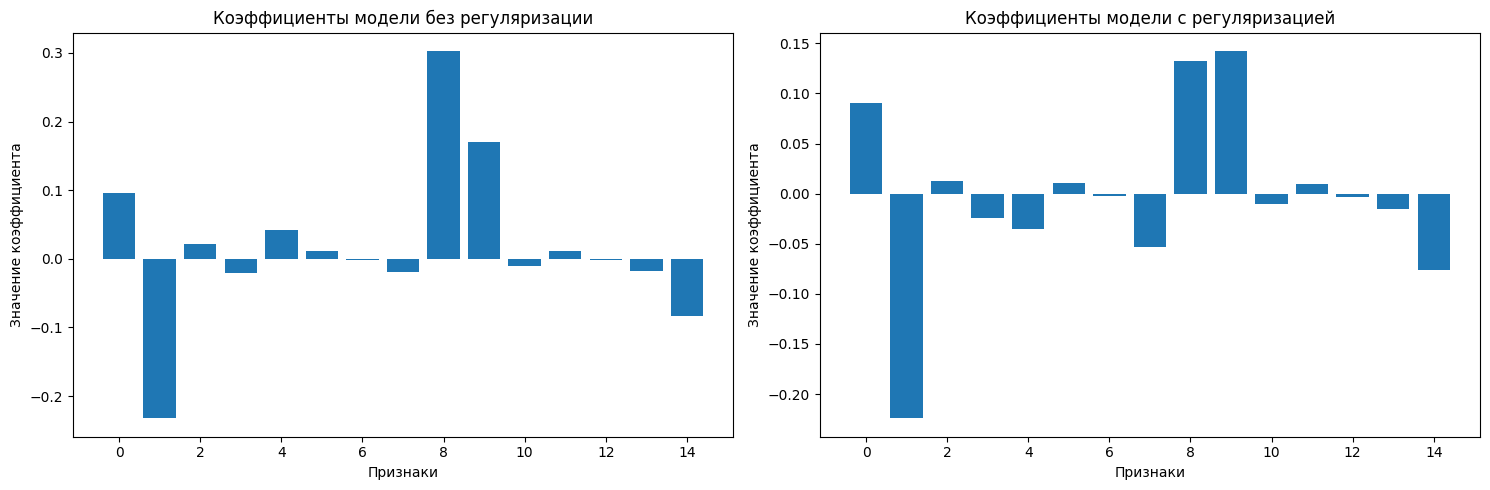

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [ ]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7562
Точность на тестовой выборке: 0.6750

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79        27
           1       0.50      0.23      0.32        13

    accuracy                           0.68        40
   macro avg       0.60      0.56      0.55        40
weighted avg       0.64      0.68      0.63        40



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

Модель, используемая при методе Wrapper проще и, вероятно, менее подвержена переобучению. Из-за этого можно выбрать её.Модель Embedded метода, хотя и использует все признаки, может иметь потенциально более высокую точность, если правильно подобрать параметры регуляризации. Самое оптимальное количество признаков - 5, при таком количестве точность наиболее высокая

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Коэффициенты модели без регуляризации: [[ 0.09585846 -0.23257363  0.02156827 -0.0209231   0.04229156  0.01068928
  -0.00225938 -0.01860928  0.30299401  0.17094546 -0.011012    0.01168064
  -0.00211029 -0.01786366 -0.08313707]]
Коэффициенты модели с регуляризацией: [[ 0.09093352 -0.22424351  0.01298122 -0.02463437 -0.03554785  0.01110293
  -0.00269751 -0.0535677   0.13220054  0.14246338 -0.01017694  0.00993692
  -0.0030494  -0.01578666 -0.07632527]]
Отобранные признаки (SFS): Index(['AGE_50', 'DBP_50', 'WT_50', 'SES', 'CL_STATUS'], dtype='object')
Коэффициенты модели после отбора признаков (SFS): [[ 0.08730706 -0.03118703 -0.00655821 -0.09465699 -0.12277069]]


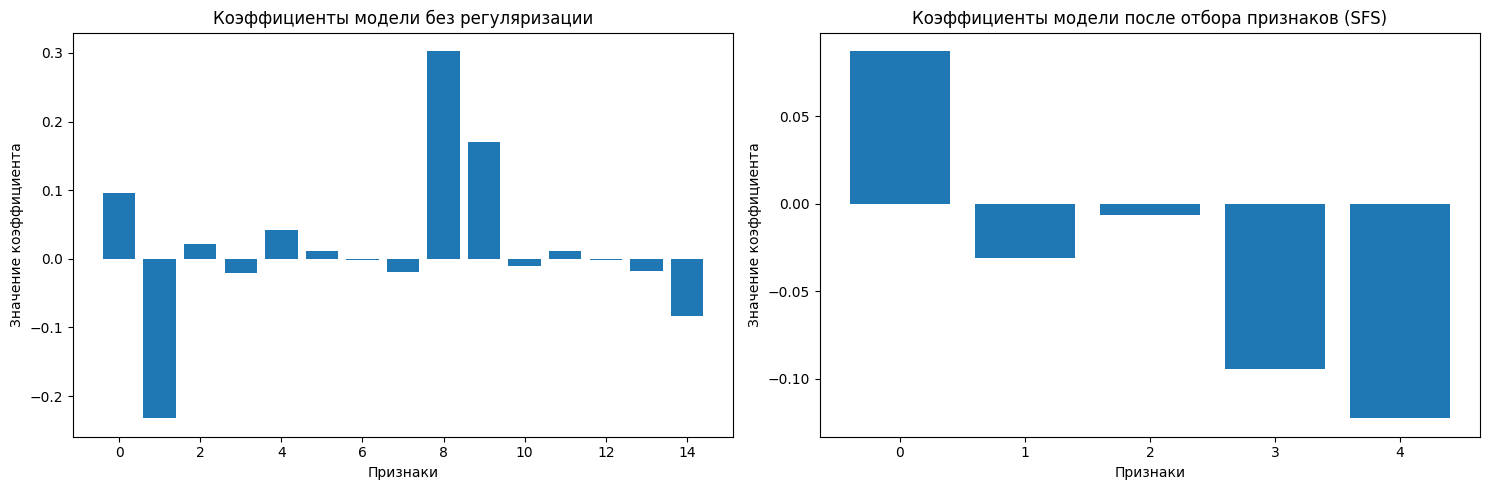

Точность на обучающей выборке: 0.7688
Точность на тестовой выборке: 0.7000

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        27
           1       0.56      0.38      0.45        13

    accuracy                           0.70        40
   macro avg       0.65      0.62      0.62        40
weighted avg       0.68      0.70      0.68        40



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Обучение модели без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Вывод коэффициентов модели
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучение модели с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Вывод коэффициентов модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SequentialFeatureSelector
sfs = SequentialFeatureSelector(model_with_penalty, n_features_to_select=5, direction='forward')
sfs.fit(X_processed, Y)

# список отобранных признаков
selected_features_sfs = X_processed.columns[sfs.get_support()]
print("Отобранные признаки (SFS):", selected_features_sfs)

# Преобразуем X_embedded в DataFrame
X_embedded_df_sfs = pd.DataFrame(sfs.transform(X_processed), columns=selected_features_sfs)

# Обучаем и оцениваем модель на отобранных признаках
model_embedded_sfs = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded_sfs.fit(X_embedded_df_sfs, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded_sfs = model_embedded_sfs.coef_
print("Коэффициенты модели после отбора признаков (SFS):", coefficients_embedded_sfs)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией (после SFS)
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_embedded_sfs[0])), coefficients_embedded_sfs[0])
plt.title("Коэффициенты модели после отбора признаков (SFS)")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

# Обучаем и оцениваем модель с использованием функции train_and_evaluate
model_sfs = train_and_evaluate(X_embedded_df_sfs, Y)

SequentialFeatureSelector  работает поэтапно, добавляя или удаляя признаки из модели, чтобы оптимизировать выбранную метрику производительности.Метод  SequentialFeatureSelector оказался менее эффективным, чем встроенный метод отбора (Embedded ), поскольку точность модели, использующей SFS, оказалась ниже.

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [ ]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [ ]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [ ]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

K-Fold Cross-Validation - Средняя точность: 0.69
Точности по каждому фолду: [0.675, 0.7, 0.675, 0.675, 0.725]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

Лучше всего подошел стандартный показатель 10. При таком подходе модель обучается на 80% данных, а тестируется на оставшихся 20%. Это хороший баланс между размером обучающей и тестовой выборок.

In [ ]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

ShuffleSplit Cross-Validation - Средняя точность: 0.6525000000000001
Точности по каждому разделению: [0.65, 0.6125, 0.675, 0.6875, 0.6375]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

При использовании n_splits=10 обеспечивается надежная оценка производительности модели, минимизируя риск переобучения за счет хорошего баланса между размером обучающей и тестовой выборок

In [ ]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=5)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.8
Точность на тестовых данных: 0.78125


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

При случайном разбиении данных с random_state=10 модель показала высокую точность (82.5%) на валидационной выборке, но значительно меньшую (около 60%) на тестовой. Это указывает на переобучение: модель заучила валидационные данные и не смогла обобщить знания на новые, невиданные данные.

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Для моего датасета наиболее подходящим методом является K-fold Cross-Validation. Так как по размеру датасет небольшой - около 200 записей. Он позволяет использовать все доступные данные для обучения и тестирования, обеспечивая более надежную оценку производительности модели